# TP : apprentissage multimodal


Dans ce TP, nous allons utiliser le modèle d'apprentissage, FashionCLIP, pré-entraîné sur des images ainsi que des descriptions en langage naturel. Plus particulièrement, nous allons considérer deux cas d'usage :

*   **Moteur de recherche d'images :** il s'agit de trouver, à partir d'une requête en langage naturel, l'image correspondante.

*   **Classification zero-shot :** il s'agit simplement de construire un classifieur d'images (faire correspondre un label à une image).



## Dataset

Nous allons dans un premier temps télécharger les données. Celles-ci provienennt de [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).

In [1]:
%%capture
!pip install gdown
!gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
!unzip data

### Modèle FashionCLIP

Nous allons également télécharger le modèle pré-entraîné.

In [2]:
%%capture
!pip install -U fashion-clip

In [3]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [4]:
%%capture
fclip = FashionCLIP('fashion-clip')

FashionCLIP, à l'instar de CLIP, crée un espace vectoriel partagé pour les images et le texte. Cela permet de nombreuses applications, telles que la recherche (trouver l'image la plus similaire à une requête donnée) ou la classification zero-shot.

Il y a principalement deux composants : un encodeur d'image (pour générer un vecteur à partir d'une image) et un encodeur de texte (pour générer un vecteur à partir d'un texte).










<img src="https://miro.medium.com/v2/resize:fit:1400/0*FLNMtW6jK51fm7Og"  width="400">



Nous allons télécharger les données que nous allons ensuite nettoyer.

In [5]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# Supprimer les éléments ayant la même description
subset = articles.drop_duplicates("detail_desc").copy()

# upprimer les images dont la catégrie n'est pas renseignée
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# Garder seulement les descriptions dont la longueur est inférieure à 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# Supprimer les articles qui ne sont pas suffisamment fréquents dans le jeu de données
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

subset.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,176754003,176754,2 Row Braided Headband (1),74,Hair/alice band,Accessories,1010016,Solid,17,Yellowish Brown,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two-strand hairband with braids in imitation s...
3,189634031,189634,Long Leg Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Leggings in stretch jersey with an elasticated...


In [6]:
subset.to_csv("subset_data.csv", index=False)
f"Il y a {len(subset)} éléments dans le dataset"

'Il y a 3104 éléments dans le dataset'

## Moteur de recherche d'images

Constuire un moteur de recherche qui permet, à partir d'une description en langage naturel, de récupérer l'image correspondante. Mesurer ses performances (précision).

<img src="https://miro.medium.com/v2/resize:fit:1400/1*cnKHgLAumVyuHuK9pkqr7A.gif"  width="800">


In [7]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# Créer les représentations vectorielles (embeddings) des images et des descriptions.
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

# we normalize the embeddings to unit norm (so that we can use dot product instead of cosine similarity to do comparisons)
image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)

100%|██████████| 97/97 [02:48<00:00,  1.73s/it]


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [00:06<00:00, 16.11it/s]


In [8]:
print(image_embeddings.shape)
print(text_embeddings.shape)

(3104, 512)
(3104, 512)


In [9]:
def search_engine(query):
    # Encode the query into a vector
    query_embedding = fclip.encode_text([query], batch_size=1)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, ord=2, axis=-1, keepdims=True)

    # Compute cosine similarity
    similarities = cosine_similarity(query_embedding, image_embeddings)

    # Find the best match
    best_match_index = np.argmax(similarities)
    img_metadata = subset.iloc[best_match_index]

    # Load and display the corresponding image
    path = "data_for_fashion_clip/" + str(img_metadata["article_id"]) + ".jpg"
    img = Image.open(path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Query: {query}\nMatch: {img_metadata['detail_desc']}")
    plt.show()


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 27.08it/s]


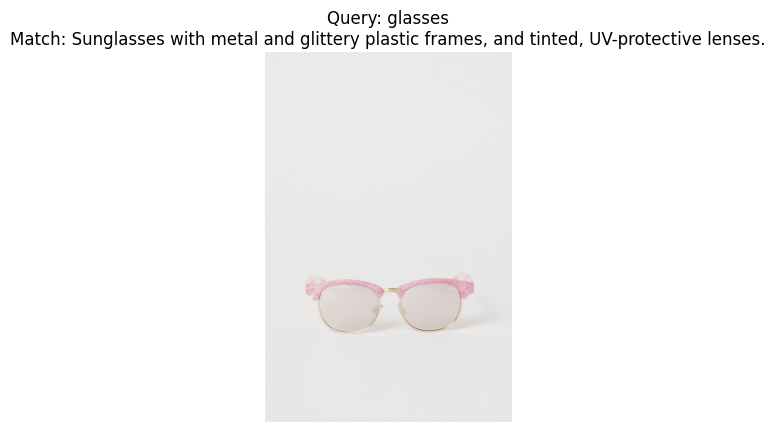

In [10]:
search_engine("glasses")

In [11]:
def search_engine_for_evaluate(query, top_k=5):
    query_embedding = fclip.encode_text([query], batch_size=1)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, ord=2, axis=-1, keepdims=True)

    similarities = cosine_similarity(query_embedding, image_embeddings)

    top_k_indices = np.argsort(similarities[0])[::-1][:top_k]
    return top_k_indices

In [12]:
def evaluate_search_engine_top_k(top_k=5):
    correct_predictions = 0
    total_queries = len(texts[:50])

    for i, query in enumerate(texts[:50]):
        # Get top-k indices
        top_k_indices = search_engine_for_evaluate(query, top_k=top_k)

        # Check if the correct article_id is among the top-k results
        ground_truth_id = subset.iloc[i]["article_id"]
        top_k_ids = subset.iloc[top_k_indices]["article_id"].tolist()

        if ground_truth_id in top_k_ids:
            correct_predictions += 1

    # Calculate precision
    precision = correct_predictions / total_queries
    print(f"Top-{top_k} Precision: {precision * 100:.2f}%")

# Evaluate the search engine with Top-5 precision
evaluate_search_engine_top_k(top_k=5)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 64.03it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 65.23it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 74.72it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 48.85it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 50.50it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 75.85it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 61.26it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 55.23it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 59.00it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 68.05it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 85.28it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 52.41it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 68.20it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 44.88it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 50.10it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 84.33it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 66.56it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 37.97it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 58.56it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 47.97it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 83.29it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 48.24it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 37.21it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 88.70it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 57.72it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 56.13it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 39.75it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 89.10it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 49.58it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 47.19it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 55.96it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 53.82it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 46.15it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 83.67it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 55.50it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 58.11it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 37.53it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 67.10it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 55.98it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 89.21it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 42.17it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 68.52it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 56.26it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 87.26it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 36.75it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 71.87it/s]

Top-5 Precision: 58.00%


## Top-5 Precision: 58.00%

Notre moteur de recherche semble bien fonctionner.

# Classification zero-shot

Construite un classsifieur d'images (prédire le label d'une image). Mesurer ses performances.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*No6ZONpQMIcfFaNMOI5oNw.gif"  width="800">



On utilisera les types de produit comme labels.

In [18]:
labels = subset["product_type_name"].unique().tolist()
labels

['Vest top',
 'Hair/alice band',
 'Leggings/Tights',
 'T-shirt',
 'Sneakers',
 'Sunglasses',
 'Cardigan',
 'Gloves',
 'Underwear Tights',
 'Hoodie',
 'Other shoe',
 'Shorts',
 'Jumpsuit/Playsuit',
 'Dress',
 'Trousers',
 'Belt',
 'Socks',
 'Underwear bottom',
 'Bodysuit',
 'Hat/beanie',
 'Scarf',
 'Jacket',
 'Other accessories',
 'Bra',
 'Swimwear bottom',
 'Blazer',
 'Top',
 'Polo shirt',
 'Sweater',
 'Necklace',
 'Pyjama set',
 'Blouse',
 'Bag',
 'Shirt',
 'Coat',
 'Boots',
 'Skirt',
 'Garment Set',
 'Bikini top',
 'Sandals',
 'Dungarees',
 'Earring',
 'Cap/peaked',
 'Ballerinas',
 'Swimsuit',
 'Hat/brim']

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
X = image_embeddings
y = subset["product_type_name"].tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000, multi_class='ovr')
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
                   precision    recall  f1-score   support

              Bag       0.73      1.00      0.84         8
       Ballerinas       0.00      0.00      0.00         4
             Belt       1.00      0.67      0.80         3
       Bikini top       1.00      0.56      0.71         9
           Blazer       1.00      0.88      0.93         8
           Blouse       0.63      0.67      0.65        18
         Bodysuit       1.00      0.17      0.29         6
            Boots       1.00      0.67      0.80         6
              Bra       0.78      1.00      0.88         7
       Cap/peaked       0.67      1.00      0.80         4
         Cardigan       1.00      0.75      0.86         4
             Coat       0.00      0.00      0.00         2
            Dress       0.72      0.91      0.81        66
        Dungarees       0.00      0.00      0.00         3
          Earring       0.88      1.00      0.94        15
      Garment Set       0.50    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Accuracy: 74.24%

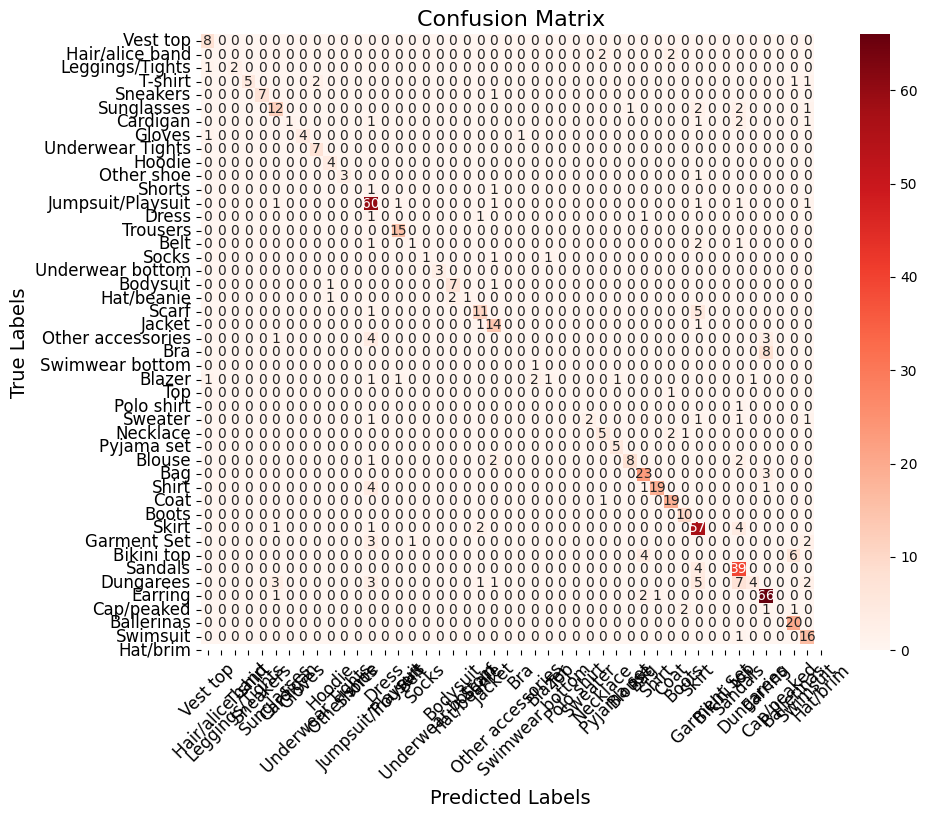

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()